# СИБУР challenge 2020
## Вторая задача: сопоставление названий 
**Коротко о задаче:**

 - Нам даны данные о названиях двух компаний в 497.819 парах названий.
 - Каждая пара названий компаний имеет разметку: 0 или 1. Это означает, что компании в паре различны или связаны, соответственно
 - Нам даные тестовые данные - 213.249 сэмплов. На тесте **требуется определить связаны ли компании.**
 
*Более подробно ознакомиться с заданием можно на официальном сайте организатора сореванования здесь - https://sibur.ai-community.com/competitions/4/tasks/12*

**Оценка решения**
 - На приватном лидер-борде решение показывает 0.7036 по f1-score и находится на 28 месте из 195. 
 
 *Ознакомиться с лидер-бордом можно здесь - https://sibur.ai-community.com/competitions/4/tasks/12/rating*
 
 
 - Следует отметить, что в решении применялся подход, который частично запрещен в рамках соревнования: был составлен и использован список названий крупных промышленных холдингов. Данный список состоит из названий компаний, которые:
     - определены вследствии анализа ошибок алгоритма;
     - определены по результатам анализа индекса джинни признака для каждого высоко-частотного слова.
 
 Более подробно о подходе указано в самой работе
 
 
 ## Дополнительные материалы
 - моя статья на Хабре, написанная по результатам первой недели соревнования - https://habr.com/ru/post/530628/
 - интересное решение участника с публичным скором выше 0.7 и красивой визуализацией - https://github.com/gorodion/Near-Duplicate-Detection/blob/master/main.ipynb

# Import libraries

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pycountry
import re

from tqdm import tqdm
tqdm.pandas()

from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.sparse import csr_matrix

import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report, f1_score


# import googletrans
# from googletrans import Translator
import cyrtranslit

# Functions

In [2]:
# convert text to lowercase
def lower_str(data,column):
    data[column] = data[column].str.lower()

In [3]:
def contingency_table(X,features,probability_level,tridx,cvidx,model):
    tr_predict_proba = model.predict_proba(X.iloc[tridx][features].values)
    cv_predict_proba = model.predict_proba(X.iloc[cvidx][features].values)

    tr_predict_target = (tr_predict_proba[:, 1] > probability_level).astype(np.int)
    cv_predict_target = (cv_predict_proba[:, 1] > probability_level).astype(np.int)

    X_tr = X.iloc[tridx]
    X_cv = X.iloc[cvidx]

    X_tr['predict_proba'] = tr_predict_proba[:,1]
    X_cv['predict_proba'] = cv_predict_proba[:,1]

    X_tr['predict_target'] = tr_predict_target
    X_cv['predict_target'] = cv_predict_target

    # make true positive column
    data = pd.DataFrame(X_tr[X_tr['target']==1][X_tr['predict_target']==1]['pair_id'])
    data['True_Positive'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==1][X_cv['predict_target']==1]['pair_id'])
    data['True_Positive'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make false positive column
    data = pd.DataFrame(X_tr[X_tr['target']==0][X_tr['predict_target']==1]['pair_id'])
    data['False_Positive'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==0][X_cv['predict_target']==1]['pair_id'])
    data['False_Positive'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make true negative column
    data = pd.DataFrame(X_tr[X_tr['target']==0][X_tr['predict_target']==0]['pair_id'])
    data['True_Negative'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==0][X_cv['predict_target']==0]['pair_id'])
    data['True_Negative'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make false negative column
    data = pd.DataFrame(X_tr[X_tr['target']==1][X_tr['predict_target']==0]['pair_id'])
    data['False_Negative'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==1][X_cv['predict_target']==0]['pair_id'])
    data['False_Negative'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')
    
    return X_tr,X_cv

In [4]:
def matrix_confusion(X):

    list_matrix = ['True_Positive','False_Positive','True_Negative','False_Negative']

    tr_pos = X[list_matrix].sum().loc['True_Positive']
    f_pos = X[list_matrix].sum().loc['False_Positive']
    tr_neg = X[list_matrix].sum().loc['True_Negative']
    f_neg = X[list_matrix].sum().loc['False_Negative']
    matrix_confusion = pd.DataFrame()
    matrix_confusion['0_algorythm'] = np.array([tr_neg,f_neg]).T
    matrix_confusion['1_algorythm'] = np.array([f_pos,tr_pos]).T
    matrix_confusion = matrix_confusion.rename(index={0: '0_target', 1: '1_target'})
    
    return matrix_confusion

In [5]:
def report_score(tr_matrix_confusion,
                 cv_matrix_confusion,
                 data,tridx,cvidx,
                 X_tr,X_cv):
    # print some imporatant information
    print ('\033[1m'+'Matrix confusion on train data'+'\033[m')
    display(tr_matrix_confusion)
    print ()
    print(classification_report(data.iloc[tridx]["target"].values, X_tr['predict_target']))
    print ('******************************************************')
    print ()
    print ()
    print ('\033[1m'+'Matrix confusion on test(cv) data'+'\033[m')
    display(cv_matrix_confusion)
    print ()
    print(classification_report(data.iloc[cvidx]["target"].values, X_cv['predict_target']))
    print ('******************************************************')

In [6]:
def table_gain_coef(model,features,start,stop):
    
    data_gain = pd.DataFrame()
    data_gain['Features'] = features
    data_gain['Gain'] = model.booster_.feature_importance(importance_type='gain')
    return data_gain.sort_values('Gain', ascending=False)[start:stop]

In [7]:
def gain_hist(df,size,start,stop):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('Gain', ascending=False)['Features'][start:stop])
    y = (df.sort_values('Gain', ascending=False)['Gain'][start:stop])
    plt.bar(x,y)
    plt.xlabel('Features')
    plt.ylabel('Gain')
    plt.xticks(rotation=90)
    plt.show()

In [8]:
def gini_df(model,features,start,stop):
    
    data_gini = pd.DataFrame()
    data_gini['feature'] = features
    data_gini['gini'] = model.feature_importances_
    return data_gini.sort_values('gini', ascending=False)[start:stop]

In [9]:
def gini_hist(df,size):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('gini', ascending=False)['feature'])
    y = (df.sort_values('gini', ascending=False)['gini'])
    plt.bar(x,y)
    plt.xlabel('feature')
    plt.ylabel('gini')
    plt.xticks(rotation=90)
    plt.show()

In [10]:
def logreg_df(model,features,start,stop):
    
    data_logreg = pd.DataFrame()
    data_logreg['feature'] = features
    data_logreg['coef'] = model.coef_.reshape(-1)
    return data_logreg.sort_values('coef', ascending=False)[start:stop]

In [11]:
def logreg_hist(df,size):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('coef', ascending=False)['feature'])
    y = (df.sort_values('coef', ascending=False)['coef'])
    plt.bar(x,y)
    plt.xlabel('feature')
    plt.ylabel('coef')
    plt.xticks(rotation=90)
    plt.show()

In [12]:
def compair_metrics(data):
    duplicate_count = []
    duplicate_sum = []
    for i in range(len(data)):
        count=len(data[i])
        duplicate_count.append(count)
        if count <= 0:
            duplicate_sum.append(0)
        elif count > 0:
            temp_sum = 0
            for j in range(len(data[i])):
                temp_sum +=len(data[i][j])
            duplicate_sum.append(temp_sum)

    return duplicate_count,duplicate_sum    

In [13]:
def transliterate(data):
    text_transliterate = []
    for i in range(data.shape[0]):
        temp_list = list(data[i:i+1])
        temp_str = ''.join(temp_list)
        result = cyrtranslit.to_latin(temp_str,'ru')
        text_transliterate.append(result)
    return text_transliterate

In [14]:
def rename_agg_columns(id_client,data,rename):
    columns = [id_client]
    for lev_0 in data.columns.levels[0]:
        if lev_0 != id_client:
            for lev_1 in data.columns.levels[1][:-1]:
                columns.append(rename % (lev_0, lev_1))
    data.columns = columns
    return data

In [15]:
# draw graph for analyse two choosing features for predict traget label
def two_features(data,analyse1,analyse2,size):
    fig = plt.subplots(figsize=size)
    
    x0 = data[data['target']==0][analyse1]
    y0 = data[data['target']==0][analyse2]
    x1 = data[data['target']==1][analyse1]
    y1 = data[data['target']==1][analyse2]
    
    plt.scatter(x1,y1,c='green',marker='.',s=400,label='duplicates')
    plt.scatter(x0,y0,c='black',marker='+',s=40,label='different words')
    plt.xlabel(analyse1)
    plt.ylabel(analyse2)
    title = [analyse1,analyse2]
    plt.title(title)
    plt.legend(loc=8,fontsize=8)
    plt.show()

In [16]:
# contingency table for categorical and discrete data

def contingency_table_2(data,analyse,title_print):
    ct = pd.crosstab(data['target'], data[analyse].fillna('no_data'))
    ct.loc['sum'] = ct.sum()
    ct.loc['duplicates_%_(1)'] = ct.loc[1]/ct.loc['sum']*100
    ct.loc['duplicates_%_(1)'] = list(map(lambda x: round(x,2), ct.loc['duplicates_%_(1)']))
    ct.loc['share_of_objects_%'] = ct.loc['sum']/ct.loc['sum'].sum(axis=0)*100
    ct.loc['share_of_objects_%'] = list(map(lambda x: round(x,1), ct.loc['share_of_objects_%']))
    
    if title_print == 'yes':
        print ('\033[1m' + 'Таблица сопряженности' + '\033[m')
    elif title_print == 'no':
        None
    
    return ct

In [17]:
# pair histogramms for categorical and discrete data

def pair_hist(ct,size,title_print):
    
    if title_print == 'yes':
        print ('Признак:','\033[1m',analyse,'\033[m')
    elif title_print == 'no':
        None
    
    width =0.3

    fig, ax = plt.subplots(figsize=(size))

    x = ct.columns
    y0 = ct.loc['share_of_objects_%']
    y1 = ct.loc['duplicates_%_(1)']
    rects1 = ax.bar(np.arange(len(x)) - width/2, y1, width, color='darkgreen', label='% duplicates')
    rects2 = ax.bar(np.arange(len(x)) + width/2, y0, width, color='black', label='% not duplicates')
    ax.set_title(analyse)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x)
    if len(x) > 10:    
            plt.xticks(rotation=90)
    ax.legend(loc=9,fontsize=8)
    plt.xlabel(analyse)
    plt.ylabel('%')
    plt.show()

# Download data

In [18]:
# DOWNLOAD DATA
text_train = pd.read_csv('train.csv')
text_test = pd.read_csv('test.csv')

In [19]:
# RENAME DATA
text_train = text_train.rename(columns={"is_duplicate": "target"})

In [20]:
# ANALYSE BALANCE OF DATA
target_1 = text_train[text_train['target']==1]['target'].count()
target_0 = text_train[text_train['target']==0]['target'].count()

print ('There are', target_1, 'objects with target 1')
print ('There are', target_0, 'objects with target 0')
print ('Balance is', round(100*target_1/target_0,2),'%')

There are 3658 objects with target 1
There are 494161 objects with target 0
Balance is 0.74 %


# Baseline preprocessing data

In [21]:
# make copy data
baseline_train = text_train.copy()
baseline_test = text_test.copy()

In [22]:
# Convert text to lowercase
columns = ['name_1','name_2']
for column in columns:
    lower_str(baseline_train,column)
for column in columns:
    lower_str(baseline_test,column)

In [23]:
# Drop any names of countries
countries = [country.name.lower() for country in pycountry.countries]
for country in tqdm(countries):
    baseline_train.replace(re.compile(country), "", inplace=True)
    baseline_test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [07:32<00:00,  1.82s/it]


In [24]:
# Drop punctuation marks
baseline_train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
baseline_test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

baseline_train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
baseline_test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [25]:
# Drop some stop-words
# HANDE-MADE list
drop_list = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt.",
             
             'retail','usa','asia','ceska republika','limited','tradig','llc','group',
             'international','plc','retail','tire','mills','chemical','korea','brasil',
             'holding','vietnam','tyre','venezuela','polska','americas','industrial','taiwan',
             'europe','america','north','czech republic','retailers','retails',
            
            'mexicana','corporation','corp','ltd','co','toronto','nederland','shanghai','gmb','pacific',
            'industries','industrias',
            
            'inc', 'ltda', 'ооо', 'зао', 'оао', 'пао', 'ceska republika', 'ltda', 
            'sibur', 'enterprises', 'electronics', 'products', 'distribution', 'logistics', 'development',
            'technologies', 'pvt', 'technologies', 'comercio', 'industria', 'trading', 'internacionais', 
            'bank', 'sports',
            
            'express','east', 'west', 'south', 'north', 'factory', 'transportes', 'trade', 'banco',
            'management', 'engineering', 'investments', 'enterprise', 'city', 'national', 'express', 'tech', 
            'auto', 'transporte', 'technology', 'and', 'central', 'american',
            
            'logistica','global','exportacao', 'ceska republika', 'vancouver', 'deutschland',
            
            'sro','rus','chemicals','private','distributors','tyres','industry','services','italia','beijing',
            
            'рус','company','the','und', 'oil']

baseline_train['name_1_non_stop_words'] =\
    baseline_train['name_1'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_train['name_2_non_stop_words'] =\
    baseline_train['name_2'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

baseline_test['name_1_non_stop_words'] =\
    baseline_test['name_1'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_test['name_2_non_stop_words'] =\
    baseline_test['name_2'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

In [26]:
baseline_train[baseline_train.name_1.str.contains("vancouver")].head(3)

,pair_id,name_1,name_2,target,name_1_non_stop_words,name_2_non_stop_words
57710,57711,binex line corp vancouver,ajover sa,0,binex line,ajover sa
157747,157748,binex line corp vancouver,anconn co ltd,0,binex line,anconn
269770,269771,binex line corp vancouver,ajc international inc,0,binex line,ajc


In [27]:
# Transliteration to latin
baseline_train['name_1_transliterated'] = transliterate(baseline_train['name_1_non_stop_words'])
baseline_train['name_2_transliterated'] = transliterate(baseline_train['name_2_non_stop_words'])
baseline_test['name_1_transliterated'] = transliterate(baseline_test['name_1_non_stop_words'])
baseline_test['name_2_transliterated'] = transliterate(baseline_test['name_2_non_stop_words'])

In [28]:
# One more time drop punctuation marks after transliteration
baseline_train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
baseline_test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

baseline_train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
baseline_test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

### Dictionary of most high-frequency words

In [29]:
#  Make dictionary of frequency all words
list_words = baseline_train['name_1_transliterated'].to_string(index=False).split() +\
                baseline_train['name_2_transliterated'].to_string(index=False).split()
freq_words = {}
for w in list_words:
    freq_words[w] = freq_words.get(w, 0) + 1
    
# Make a dataset from dictionary of frequency all words
df_freq = pd.DataFrame.from_dict(freq_words,orient='index').reset_index()
df_freq.columns = ['word','frequency']
df_freq_agg = df_freq.groupby(['word']).agg([sum]).reset_index()
df_freq_agg = rename_agg_columns(id_client='word',data=df_freq_agg,rename='%s_%s')
df_freq_agg = df_freq_agg.sort_values(by=['frequency_sum'], ascending=False)

In [ ]:
# df_freq_agg[0:50]

In [30]:
# Drop top 50 common words (NAME 1 & NAME 2)
drop_list = list(df_freq_agg[0:50]['word'].to_string(index=False).split())

baseline_train['name_1_finish'] =\
    baseline_train['name_1_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_train['name_2_finish'] =\
    baseline_train['name_2_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

baseline_test['name_1_finish'] =\
    baseline_test['name_1_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_test['name_2_finish'] =\
    baseline_test['name_2_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

In [ ]:
# baseline_train[baseline_train.name_1_finish.str.contains("logistic")]

# Features

**Create label 1, if names of both companies in the pair are empty, else create label 0**

In [31]:
# Create label if name_1_finish=name_2_finish=empty ('')

# FOR TRAIN
df = pd.DataFrame(baseline_train[baseline_train['name_1_finish']==''][
    baseline_train['name_2_finish']=='']['pair_id'])
df['empty_after_all'] = 1
baseline_train = baseline_train.merge(df,on='pair_id',how='left')
baseline_train['empty_after_all'] = baseline_train['empty_after_all'].fillna(0)

# FOR TEST
df = pd.DataFrame(baseline_test[baseline_test['name_1_finish']==''][
    baseline_test['name_2_finish']=='']['pair_id'])
df['empty_after_all'] = 1
baseline_test = baseline_test.merge(df,on='pair_id',how='left')
baseline_test['empty_after_all'] = baseline_test['empty_after_all'].fillna(0)

**Count levenstein distance and normalized levenstain distance**

In [32]:
# Create feature with LEVENSTAIN DISTANCE
levenshtein = Levenshtein()
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

baseline_train["levenstein"] = baseline_train.progress_apply(
    lambda r: levenshtein.distance(r[column_1], r[column_2]), axis=1)
baseline_test["levenstein"] = baseline_test.progress_apply(
    lambda r: levenshtein.distance(r[column_1], r[column_2]), axis=1)

100%|██████████| 213249/213249 [00:14<00:00, 14252.55it/s]


In [33]:
# Create feature with NORMALIZATION LEVENSTAIN DISTANCE
normalized_levenshtein = NormalizedLevenshtein()
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

baseline_train["norm_levenstein"] = baseline_train.progress_apply(
    lambda r: normalized_levenshtein.distance(r[column_1], r[column_2]),axis=1)
baseline_test["norm_levenstein"] = baseline_test.progress_apply(
    lambda r: normalized_levenshtein.distance(r[column_1], r[column_2]),axis=1)

100%|██████████| 213249/213249 [00:15<00:00, 13867.01it/s]


**Сreate features containing information about similar and different words and symbols in pairs:**
 - duplicate_count - **similar word count**
 - duplicate_sum - symbol count of similar words
 - duplicate_mean - ratio between symbol and similar word count (average number of symbols in a similar word)
 - dif_count - **different word count**
 - dif_sum - symbol count of different words
 - dif_mean - ratio between symbol and different word count (average number of symbols in a different word)
 - ratio_duplicate/dif_count - ratio between similar and different words in the pair
 
Use function 'compair_metrics'

In [34]:
# Make some information about duplicates and differences 
# for TRAIN
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

duplicates = []
difference = []

for i in range(baseline_train.shape[0]):
    list1 = list(baseline_train[i:i+1][column_1])
    str1 = ''.join(list1).split()
    list2 = list(baseline_train[i:i+1][column_2])
    str2 = ''.join(list2).split()
    
    duplicates.append(list(set(str1) & set(str2)))
    difference.append(list(set(str1).symmetric_difference(set(str2))))
    
# continue make information about duplicates
duplicate_count,duplicate_sum = compair_metrics(duplicates)
dif_count,dif_sum = compair_metrics(difference)

In [35]:
# Create features has information about duplicates and differences 
# for TRAIN
baseline_train['duplicate'] = duplicates
baseline_train['difference'] = difference

baseline_train['duplicate_count'] = duplicate_count
baseline_train['duplicate_sum'] = duplicate_sum
baseline_train['duplicate_mean'] = baseline_train['duplicate_sum'] / baseline_train['duplicate_count']
baseline_train['duplicate_mean'] = baseline_train['duplicate_mean'].fillna(0)

baseline_train['dif_count'] = dif_count
baseline_train['dif_sum'] = dif_sum
baseline_train['dif_mean'] = baseline_train['dif_sum'] / baseline_train['dif_count']
baseline_train['dif_mean'] = baseline_train['dif_mean'].fillna(0)

In [36]:
# create ratio duplicate words count to differences words count in the pair
# for TRAIN
baseline_train['ratio_duplicate/dif_count'] = baseline_train['duplicate_count'] / baseline_train['dif_count']

In [37]:
# make some information about duplicates and differences 
# for TEST
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

duplicates = []
difference = []

for i in range(baseline_test.shape[0]):
    list1 = list(baseline_test[i:i+1][column_1])
    str1 = ''.join(list1).split()
    list2 = list(baseline_test[i:i+1][column_2])
    str2 = ''.join(list2).split()
    
    duplicates.append(list(set(str1) & set(str2)))
    difference.append(list(set(str1).symmetric_difference(set(str2))))
    
# continue make information about duplicates
duplicate_count,duplicate_sum = compair_metrics(duplicates)
dif_count,dif_sum = compair_metrics(difference)

In [38]:
# create features have information about duplicates and differences 
# for TEST
baseline_test['duplicate'] = duplicates
baseline_test['difference'] = difference

baseline_test['duplicate_count'] = duplicate_count
baseline_test['duplicate_sum'] = duplicate_sum
baseline_test['duplicate_mean'] = baseline_test['duplicate_sum'] / baseline_test['duplicate_count']
baseline_test['duplicate_mean'] = baseline_test['duplicate_mean'].fillna(0)

baseline_test['dif_count'] = dif_count
baseline_test['dif_sum'] = dif_sum
baseline_test['dif_mean'] = baseline_test['dif_sum'] / baseline_test['dif_count']
baseline_test['dif_mean'] = baseline_test['dif_mean'].fillna(0)

In [39]:
# create ratio duplicate words count to differences words count in the pair
# for TEST
baseline_test['ratio_duplicate/dif_count'] = baseline_test['duplicate_count'] / baseline_test['dif_count']

### *Dictionary of most important names holdings*

*The use of such a dictionary is prohibited by the rules of the competition*

*We created this dictionary using the following approaches:*
 - *manual viewing of algorithm errors that did not use a list of holding names*
 - *selection of the most significant frequent words by ginny index*

In [40]:
# we used just for check f1 with that list of holdings
list_top_companies = ['accessories', 'arlanxeo', 'basf', 'bayer', 'bdp', 'bosch', 'bostik',
                      'brenntag','bridgestone',
                      'celanese','contitech','continental',
                      'daewoo', 'dow', 'dupont', 'evonik', 'eurovia', 'exxon', 'exxonmobil', 'freudenberg',
                      'goodyear', 'goter', 'gymap', 'hannifin', 'henkel', 'hp', 'hyundai', 
                      'iko', 'insaat', 'isover', 'itochu', 'kia', 'knauf',
                      'kraton', 'kumho', 'lusocopla', 'michelin', 'mondi', 
                      'paul bauder', 'paul', 'pirelli', 'puma', 'ravago',
                      'rehau', 'reliance', 'sabic', 'saintgobain', 'sanyo', 'shell', 
                      'sherwinwilliams','showa',
                      'sika', 'sirketi', 'sojitz',
                      'soprema', 'steico', 'strabag', 'sumitomo', 'synthomer', 'synthos','swisspor',
                      'taban', 'total', 'trelleborg', 'tremco', 'trinseo', 'versalis', 'yokohama','zeon']

In [ ]:
# names = [
#  'hannifin',
#  'swisspor',
#  'tremco',
#  'saintgobain',
#  'puma',
#  'bostik',
#  'insaat',
#  'sirketi']

# names = ['continental',
#  'bridgestone',
#  'basf',
#  'sika',
#  'zeon',
#  'soprema',
#  'michelin',
#  'pirelli',
#  'arlanxeo',
#  'sumitomo',
#  'reliance',
#  'paul',
#  'exxonmobil',
#  'contitech',
#  'synthomer',
#  'dow',
#  'yokohama',
#  'kraton',
#  'iko',
#  'eurovia',
#  'accessories',
#  'total',
#  'kumho',
#  'celanese',
#  'ravago',
#  'showa',
#  'versalis',
#  'gymap',
#  'taban',
#  'synthos',
#  'mondi']

**Create feature:**
   - count repeated words between the list names top companies and dublicates in the pair

In [41]:
# create information about duplicate name of petrochemical companies from top list
list_top_companies = list_top_companies

dp_train = []
for i in list(baseline_train['duplicate']):
    dp_train.append(''.join(list(set(i) & set(list_top_companies))))
    
dp_test = []
for i in list(baseline_test['duplicate']):
    dp_test.append(''.join(list(set(i) & set(list_top_companies))))
    
baseline_train['duplicate_name_company'] = dp_train
baseline_test['duplicate_name_company'] = dp_test

# replace name duplicate to number
baseline_train['duplicate_name_company'] =\
    baseline_train['duplicate_name_company'].replace('',0,regex=True)
baseline_train.loc[baseline_train['duplicate_name_company'] != 0, 'duplicate_name_company'] = 1

baseline_test['duplicate_name_company'] =\
    baseline_test['duplicate_name_company'].replace('',0,regex=True)
baseline_test.loc[baseline_test['duplicate_name_company'] != 0, 'duplicate_name_company'] = 1

**We didn't use next features**

In [ ]:
# # create some important feature about similar words in the data and names of top companies for TRAIN
# # (levenstein distance, length of word, ratio distance to length)
# baseline_train = dist_name_to_top_list_make(baseline_train,
#                       'name_1_finish','name_2_finish',list_top_companies)

In [ ]:
# # create some important feature about similar words in the data and names of top companies for TEST
# # (levenstein distance, length of word, ratio distance to length)
# baseline_test = dist_name_to_top_list_make(baseline_test,
#                       'name_1_finish','name_2_finish',list_top_companies)

### Matrix of high-frequency words

Create matrix of 650 high-frequency words (h/f words)

The creating matrix of 650 h/f words process needs a very long time. That way we decided download matrix in csv file. 

Now we can download matrix of h/f words and merge it with data train and test data

In [42]:
# download matrix of most frequency words
df_stop_words_train = pd.read_csv('matrix_sw_train_650.csv',index_col=0)
df_stop_words_test = pd.read_csv('matrix_sw_test_650.csv',index_col=0)

In [ ]:
# # Create matrix of stop-words and fix some columns
# # FOR TRAIN
# df_stop_words_train = pd.DataFrame()
# df_stop_words_train['pair_id'] = baseline_train['pair_id']
# df_stop_words_train['name_1_finish'] = baseline_train['name_1_finish']
# df_stop_words_train['name_2_finish'] = baseline_train['name_2_finish']

In [ ]:
# # Create matrix of stop-words and fix some columns
# # FOR TEST
# df_stop_words_test = pd.DataFrame()
# df_stop_words_test['pair_id'] = baseline_test['pair_id']
# df_stop_words_test['name_1_finish'] = baseline_test['name_1_finish']
# df_stop_words_test['name_2_finish'] = baseline_test['name_2_finish']

In [43]:
# Merge baseline data with matrix of stop words
# FOR TRAIN

baseline_train = baseline_train.merge(
    df_stop_words_train.drop(['name_1_finish','name_2_finish'],axis=1), on='pair_id', how='left')

In [44]:
# Merge baseline data with matrix of stop words
# FOR TEST

baseline_test = baseline_test.merge(
    df_stop_words_test.drop(['name_1_finish','name_2_finish'],axis=1), on='pair_id', how='left')

In [45]:
baseline_train.columns[23:]

Index(['de_sum', 'sa_sum', 'cv_sum', 'rubber_sum', 's_sum', 'a_sum', 'imp_sum',
       'exp_sum', 'plastic_sum', 'e_sum',
       ...
       'abc_sum', 'swan_sum', 'ceat_sum', 'mat_sum', 'tedder_sum',
       'abrasives_sum', 'neumaticos_sum', 'ktn_sum', 'ming_sum', 'amster_sum'],
      dtype='object', length=650)

In [ ]:
# 0 - 50 - done
# 50 - 100 - done
# 100 - 150 - done
# 150 - 200 - done
# 200 - 250 - done
# 250 - 300 - done
# 300 - 350 - done
# 350 - 400 - done
# 400 - 450 - done
# 450 - 500 - done
# 500 - 550 - done
# 550 - 600 - done
# 600 - 650 - done

In [ ]:
# # Upgrade matrix of stop-words - append new stop-words in data frame
# # FOR TRAIN

# # There are three meanings for each stop word: 0,1,2
# # 0 - means no stop words in both companies of the pair
# # 1 - means one stop word in any company name from a pair
# # 2 - means that each company name from a pair has a stop word

# list_stop_words = list(df_freq_agg[600:650]['word'].to_string(index=False).split())

# name_company = 'name_1_finish'
# df_stop_words_train[name_company] = baseline_train[name_company]
# columns_drop = []
# for stop_word in list_stop_words:
#     column = 'n1_%s' % stop_word
#     columns_drop.append(column)
#     df_stop_words_train[column] = baseline_train[name_company]
#     df_stop_words_train[column] = baseline_train[name_company].apply(
#         lambda x: ' '.join(['1' for i in x.split() if i == stop_word]))
#     df_stop_words_train.loc[df_stop_words_train[column]!='',column]=1
#     df_stop_words_train.loc[df_stop_words_train[column]=='',column]=0

# name_company = 'name_2_finish'
# df_stop_words_train[name_company] = baseline_train[name_company]
# for stop_word in list_stop_words:
#     column = 'n2_%s' % stop_word
#     columns_drop.append(column)
#     df_stop_words_train[column] = baseline_train[name_company]
#     df_stop_words_train[column] = baseline_train[name_company].apply(
#         lambda x: ' '.join(['1' for i in x.split() if i == stop_word]))
#     df_stop_words_train.loc[df_stop_words_train[column]!='',column]=1
#     df_stop_words_train.loc[df_stop_words_train[column]=='',column]=0    
    
# for stop_word in list_stop_words:   
#     column = '%s_sum' % stop_word
#     n1 = 'n1_%s' % stop_word
#     n2 = 'n2_%s' % stop_word
#     df_stop_words_train[column] = df_stop_words_train[n1] + df_stop_words_train[n2]
    
# df_stop_words_train = df_stop_words_train.drop(columns_drop,axis=1)    

In [ ]:
# # Upgrade matrix of stop-words - append new stop-words in data frame
# # FOR TEST

# # There are three meanings for each stop word: 0,1,2
# # 0 - means no stop words in both companies of the pair
# # 1 - means one stop word in any company name from a pair
# # 2 - means that each company name from a pair has a stop word

# name_company = 'name_1_finish'
# df_stop_words_test[name_company] = baseline_test[name_company]
# columns_drop = []
# for stop_word in list_stop_words:
#     column = 'n1_%s' % stop_word
#     columns_drop.append(column)
#     df_stop_words_test[column] = baseline_test[name_company]
#     df_stop_words_test[column] = baseline_test[name_company].apply(
#         lambda x: ' '.join(['1' for i in x.split() if i == stop_word]))
#     df_stop_words_test.loc[df_stop_words_test[column]!='',column]=1
#     df_stop_words_test.loc[df_stop_words_test[column]=='',column]=0
    
# name_company = 'name_2_finish'
# df_stop_words_test[name_company] = baseline_test[name_company]
# for stop_word in list_stop_words:
#     column = 'n2_%s' % stop_word
#     columns_drop.append(column)
#     df_stop_words_test[column] = baseline_test[name_company]
#     df_stop_words_test[column] = baseline_test[name_company].apply(
#         lambda x: ' '.join(['1' for i in x.split() if i == stop_word]))
#     df_stop_words_test.loc[df_stop_words_test[column]!='',column]=1
#     df_stop_words_test.loc[df_stop_words_test[column]=='',column]=0    
    
# for stop_word in list_stop_words:   
#     column = '%s_sum' % stop_word
#     n1 = 'n1_%s' % stop_word
#     n2 = 'n2_%s' % stop_word
#     df_stop_words_test[column] = df_stop_words_test[n1] + df_stop_words_test[n2]
    
# df_stop_words_test = df_stop_words_test.drop(columns_drop,axis=1)    

In [ ]:
# df_stop_words_train.to_csv('matrix_sw_train_650.csv')
# df_stop_words_test.to_csv('matrix_sw_test_650.csv')

In [46]:
baseline_train.columns[23:]

Index(['de_sum', 'sa_sum', 'cv_sum', 'rubber_sum', 's_sum', 'a_sum', 'imp_sum',
       'exp_sum', 'plastic_sum', 'e_sum',
       ...
       'abc_sum', 'swan_sum', 'ceat_sum', 'mat_sum', 'tedder_sum',
       'abrasives_sum', 'neumaticos_sum', 'ktn_sum', 'ming_sum', 'amster_sum'],
      dtype='object', length=650)

In [48]:
baseline_test.columns[22:]

Index(['de_sum', 'sa_sum', 'cv_sum', 'rubber_sum', 's_sum', 'a_sum', 'imp_sum',
       'exp_sum', 'plastic_sum', 'e_sum',
       ...
       'abc_sum', 'swan_sum', 'ceat_sum', 'mat_sum', 'tedder_sum',
       'abrasives_sum', 'neumaticos_sum', 'ktn_sum', 'ming_sum', 'amster_sum'],
      dtype='object', length=650)

**Create two features:**
 - Count most common words in the pair 
 - The proportion of high-frequency words in all words in a pair

In [49]:
# Create feature: count of all stop-words in the pair
# for TRAIN

columns_sum = list(baseline_train.columns[23:])
baseline_train['stop_word_sum'] = baseline_train[columns_sum].sum(axis=1)

In [50]:
# Create feature: count of all stop-words in the pair
# for TEST

baseline_test['stop_word_sum'] = baseline_test[columns_sum].sum(axis=1)

In [51]:
# Create feature: ratio between all unique words in the pair and all unique stop words in the pair

baseline_train['ratio_all_words_stop_words'] = \
    (baseline_train['duplicate_count'] + baseline_train['dif_count']) / baseline_train['stop_word_sum']

baseline_test['ratio_all_words_stop_words'] = \
    (baseline_test['duplicate_count'] + baseline_test['dif_count']) / baseline_test['stop_word_sum']

In [ ]:
# baseline_train.columns[-5:]

In [ ]:
# list(df_freq_agg[0:300]['word'].to_string(index=False).split())

**Drop the 300 high-frequency words in all names of companies**

**Create three features:**
 - the first one is a **levenstein distance after drop all high-frequency words**
 - the second one is a **label if the both names of companies have zero words (they are empty)**: 
        - label 0 when here is empty in names of companies
        - label 1 else
 - the third one is a **ratio between levenstein distance after drop h/f words and label if names are empty**

In [52]:
# Create drop list        
drop_list = list(df_freq_agg[0:300]['word'].to_string(index=False).split())

In [53]:
# Drop the 300 top frequency words in all pairs

baseline_train['name_1_finish_drop_sw'] =\
    baseline_train['name_1_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_train['name_2_finish_drop_sw'] =\
    baseline_train['name_2_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

baseline_test['name_1_finish_drop_sw'] =\
    baseline_test['name_1_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_test['name_2_finish_drop_sw'] =\
    baseline_test['name_2_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

In [54]:
# Create feature: LEVENSTAIN DISTANCE between names of companies after drop 300 top frequency words

levenshtein = Levenshtein()
column_1 = 'name_1_finish_drop_sw'
column_2 = 'name_2_finish_drop_sw'

baseline_train["levenstein_drop_sw"] = baseline_train.progress_apply(
    lambda r: levenshtein.distance(r[column_1], r[column_2]), axis=1)
baseline_test["levenstein_drop_sw"] = baseline_test.progress_apply(
    lambda r: levenshtein.distance(r[column_1], r[column_2]), axis=1)

100%|██████████| 213249/213249 [00:16<00:00, 12879.33it/s]


In [ ]:
# baseline_train[['name_1_finish_drop_sw','name_2_finish_drop_sw','levenstein_drop_sw']]

In [ ]:
# baseline_train[['name_1','name_2','name_1_finish_drop_sw','name_2_finish_drop_sw','levenstein_drop_sw','target']][
#     baseline_train['levenstein_drop_sw']==0][baseline_train['target']==1]

In [55]:
# Create feature with two unique values:
#     0, if no words in both names companies
#     1 in any else cases
# for TRAIN

df = pd.DataFrame(baseline_train[baseline_train['name_1_finish_drop_sw']==''][
    baseline_train['name_2_finish_drop_sw']=='']['pair_id'])
df['label_zero'] = 0
baseline_train = baseline_train.merge(df,on='pair_id',how='left')
baseline_train['label_zero'] = baseline_train['label_zero'].fillna(1)

# Create feature with two unique values:
#     0, if no words in both names companies
#     1 in any else cases
# for TEST

df = pd.DataFrame(baseline_test[baseline_test['name_1_finish_drop_sw']==''][
    baseline_test['name_2_finish_drop_sw']=='']['pair_id'])
df['label_zero'] = 0
baseline_test = baseline_test.merge(df,on='pair_id',how='left')
baseline_test['label_zero'] = baseline_test['label_zero'].fillna(1)

In [56]:
# Create feature: ratio between levenstein distances and label all empty names companies in the pair
# for TRAIN
baseline_train['ratio_lvstn_drop_sw_to_label_zero'] =\
        baseline_train['levenstein_drop_sw'] / baseline_train['label_zero']

baseline_test['ratio_lvstn_drop_sw_to_label_zero'] =\
        baseline_test['levenstein_drop_sw'] / baseline_test['label_zero']

In [57]:
# baseline_train[['name_1_finish_drop_sw','name_2_finish_drop_sw',
#                 'levenstein_drop_sw','label_zero','ratio_lvstn_drop_sw_to_label_zero']]

In [58]:
# Create feature: NORMILIZED LEVENSTAIN DISTANCE between names of companies after drop 300 top frequency words

levenshtein = Levenshtein()
column_1 = 'name_1_finish_drop_sw'
column_2 = 'name_2_finish_drop_sw'

baseline_train["norm_levenstein_drop_sw"] = baseline_train.progress_apply(
    lambda r: normalized_levenshtein.distance(r[column_1], r[column_2]), axis=1)
baseline_test["norm_levenstein_drop_sw"] = baseline_test.progress_apply(
    lambda r: normalized_levenshtein.distance(r[column_1], r[column_2]), axis=1)

100%|██████████| 213249/213249 [00:16<00:00, 12799.57it/s]


In [59]:
# Create feature: ratio between levenstein distances and label all empty names companies in the pair
# for TRAIN
baseline_train['ratio_norm_lvstn_drop_sw_to_label_zero'] =\
        baseline_train['norm_levenstein_drop_sw'] / baseline_train['label_zero']

baseline_test['ratio_norm_lvstn_drop_sw_to_label_zero'] =\
        baseline_test['norm_levenstein_drop_sw'] / baseline_test['label_zero']

# MODELING part 1


## Just use light GBM for predict on train and test samples
Next model is only light gbm

In [ ]:
# # check the columns
# print (list(baseline_train.columns[23:-9]))

In [60]:
# select most important features by gini index
features = ['empty_after_all',
#             'levenstein','norm_levenstein',
            'duplicate_count', 'duplicate_sum', 'duplicate_mean',
            'dif_count', 'dif_sum', 'dif_mean', 'ratio_duplicate/dif_count',
            
            'duplicate_name_company',
            
#             'levenstein_dist_w1_top_w_min', 'levenstein_dist_w2_top_w_min'
#             , 'length_w1_top_w_min', 'length_w2_top_w_min', 'length_top_w_min',
#             'ratio_dist_w1_to_top_w_min', 'ratio_dist_w2_to_top_w_min',
            
            'stop_word_sum', 'ratio_all_words_stop_words', 
            
#             'levenstein_drop_sw', 'label_zero', 
            
            'ratio_lvstn_drop_sw_to_label_zero'
#             'ratio_norm_lvstn_drop_sw_to_label_zero'
            
           
           ]

seed = 42

In [61]:
# provides train/test indices to split data in train/test sets
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)

tridx, cvidx = list(split.split(baseline_train[features],
                                baseline_train["target"]))[0]

print ('Split baseline data train',baseline_train.shape[0])
print (' - new train data:',tridx.shape[0])
print (' - new test data:',cvidx.shape[0])

Split baseline data train 497819
 - new train data: 398255
 - new test data: 99564


In [62]:
# learning Light GBM Classificier
seed = 50
params = {'n_estimators': 1,
          'objective': 'binary',
          'max_depth': 40,
          'min_child_samples': 15,
          'learning_rate': 1,
          'random_state': seed}

model = lgb.LGBMClassifier(**params)
model.fit(baseline_train.iloc[tridx][features].values,
          baseline_train.iloc[tridx]["target"].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1, max_depth=40,
               min_child_samples=15, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [63]:
# make predict proba and predict target
probability_level = 0.99
X = baseline_train
tridx = tridx
cvidx = cvidx
model = model

X_tr, X_cv = contingency_table(X,features,probability_level,tridx,cvidx,model)

train_matrix_confusion = matrix_confusion(X_tr)
cv_matrix_confusion = matrix_confusion(X_cv)

In [64]:
# check the report
report_score(train_matrix_confusion,
             cv_matrix_confusion,
             baseline_train,
             tridx,cvidx,
             X_tr,X_cv)

Matrix confusion on train data


,0_algorythm,1_algorythm
0_target,394688.0,641.0
1_target,290.0,2636.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395329
           1       0.80      0.90      0.85      2926

    accuracy                           1.00    398255
   macro avg       0.90      0.95      0.92    398255
weighted avg       1.00      1.00      1.00    398255

******************************************************


Matrix confusion on test(cv) data


,0_algorythm,1_algorythm
0_target,98672.0,160.0
1_target,71.0,661.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.81      0.90      0.85       732

    accuracy                           1.00     99564
   macro avg       0.90      0.95      0.93     99564
weighted avg       1.00      1.00      1.00     99564

******************************************************


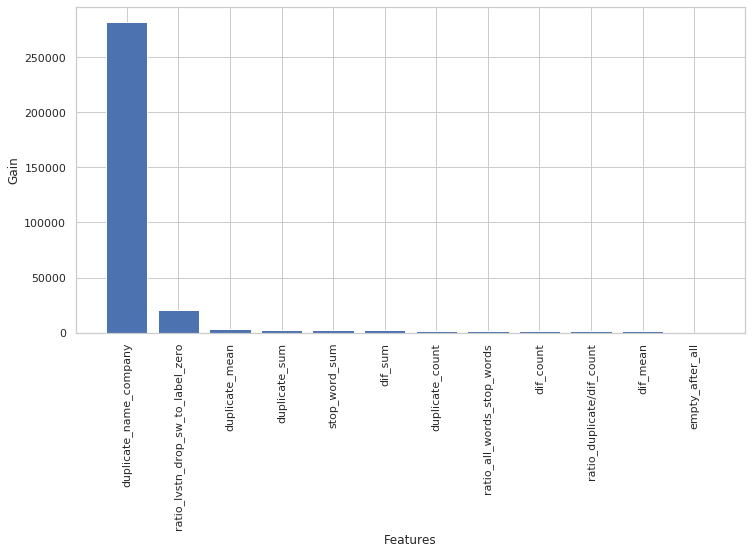

,Features,Gain
8,duplicate_name_company,281556.000000
11,ratio_lvstn_drop_sw_to_label_zero,20763.248383
3,duplicate_mean,3629.288025
2,duplicate_sum,2454.520935
9,stop_word_sum,2431.027954
5,dif_sum,2094.691956
1,duplicate_count,2080.580078
10,ratio_all_words_stop_words,1696.354980
4,dif_count,1526.122040
7,ratio_duplicate/dif_count,1511.890015


In [65]:
# look at the graph of the most gain information in the features
start = 0
stop = 25
size = (12,6)

df = table_gain_coef(model,features,start,stop)
gain_hist(df,size,start,stop)
display(df)

## Check the model on all train samples before download predicts to validation

In [66]:
# fit the model
model = lgb.LGBMClassifier(**params)
model.fit(baseline_train[features].values,
          baseline_train["target"].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1, max_depth=40,
               min_child_samples=15, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [67]:
# make predict proba and predict target on train data
baseline_train['predict_to_csv'] = (model.predict_proba(
    baseline_train[features].values)[:, 1] > probability_level).astype(np.int)

# make predict proba and predict target on TEST data
baseline_test['predict_to_csv'] = (model.predict_proba(
    baseline_test[features].values)[:, 1] > probability_level).astype(np.int)

In [68]:
# predict balance on train
baseline_train['predict_to_csv'].value_counts()

0    493835
1      3984
Name: predict_to_csv, dtype: int64

In [69]:
# predict balance on test
baseline_test['predict_to_csv'].value_counts()

0    212080
1      1169
Name: predict_to_csv, dtype: int64

In [70]:
# report about precision, recall and f-1 score
print (classification_report(baseline_train["target"].values, baseline_train['predict_to_csv']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    494161
           1       0.82      0.89      0.86      3658

    accuracy                           1.00    497819
   macro avg       0.91      0.95      0.93    497819
weighted avg       1.00      1.00      1.00    497819



In [71]:
# make predict proba and predict target on train data
baseline_train['predict_proba_to_csv'] = 1-(model.predict_proba(
    baseline_train[features].values)[:, 0].astype(np.float))

# make predict proba and predict target on test data
baseline_test['predict_proba_to_csv'] = 1-(model.predict_proba(
    baseline_test[features].values)[:, 0].astype(np.float))

Look how predict proba (that the pair contains the common companys)

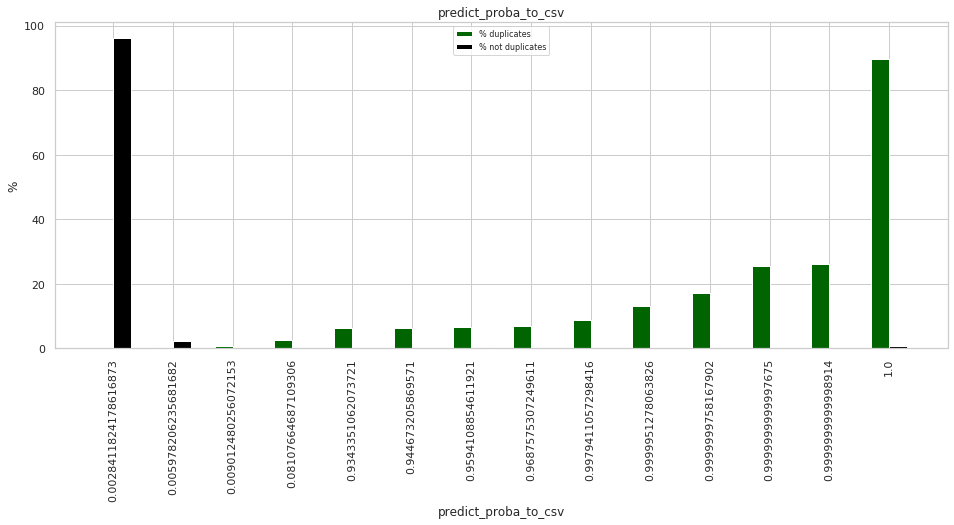

predict_proba_to_csv,0.002841,0.005978,0.009012,0.081077,0.934335,0.944673,0.959411,0.968758,0.997941,0.999995,1.000000,1.000000,1.000000,1.000000
target,,,,,,,,,,,,,,
0,478874.00,11760.00,224.00,1150.00,15.00,44.00,1340.00,41.00,31.00,177.00,63.00,35.00,34.00,373.00
1,184.00,69.00,2.00,30.00,1.00,3.00,95.00,3.00,3.00,27.00,13.00,12.00,12.00,3204.00
sum,479058.00,11829.00,226.00,1180.00,16.00,47.00,1435.00,44.00,34.00,204.00,76.00,47.00,46.00,3577.00
duplicates_%_(1),0.04,0.58,0.88,2.54,6.25,6.38,6.62,6.82,8.82,13.24,17.11,25.53,26.09,89.57
share_of_objects_%,96.20,2.40,0.00,0.20,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.70


In [72]:
# make vizualization
data = baseline_train
analyse = 'predict_proba_to_csv'
title_print = 'no'
size = (16,6)

ct = contingency_table_2(data,analyse,title_print)
pair_hist(ct,size,title_print)
display(ct)

We see model make a lot mistakes on the duplicates when proba is less than 0.1 (286 samples) and when proba is 0.959411 (95 samples)

And we can see a lot the different companies (1340) when proba is 0.959411. 

That why we use probability level is more than 0.99

Look the sccatter plot of predict proba and feature 'Ratio between levenstein distance and h/f word count'

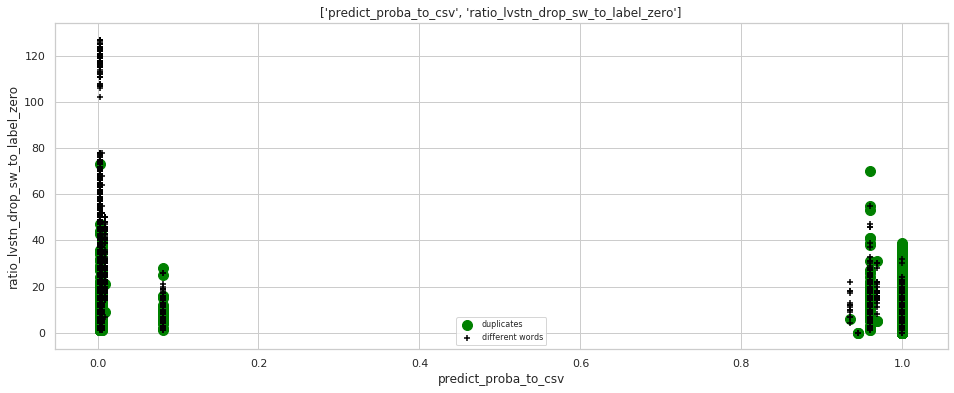

In [73]:
# scatter plot of two features (target and h/f word count)
data = baseline_train
analyse1 = 'predict_proba_to_csv'
analyse2 = 'ratio_lvstn_drop_sw_to_label_zero'
size = (16,6)
two_features(data,analyse1,analyse2,size)

Not very good :)

Check the predict balance on data test

In [74]:
# predict balance on test
baseline_test['predict_to_csv'].value_counts()

0    212080
1      1169
Name: predict_to_csv, dtype: int64

In [75]:
# select only dublicates names and look id, each name of companies and predict is the duplicate
baseline_test[baseline_test['predict_to_csv']==1][[
    'pair_id','name_1','name_2','predict_to_csv'
]]

,pair_id,name_1,name_2,predict_to_csv
40,41,continental air control ltd,continental powertrain usa llc,1
114,115,nokian tyres plc,ооо нокиан тайерс,1
285,286,ineos styrolution ltd,styrolution america llc,1
306,307,canadian saddlery supply inc,canadian saddlery supply in,1
362,363,trelleborg ysh sa de cv,trelleborg engineeed products a,1
...,...,...,...,...
211827,211828,sojitz co ltd,sojitz,1
211891,211892,jm logistics services sa de cv,jm lord international llc,1
211951,211952,sanyo corp,sanyo trading,1
212072,212073,goodyear do brasil productos de borracha ltda,goodyear inc,1


In [76]:
# select only NOT dublicates names and look id, each name of companies and predict is the duplicate
baseline_test[baseline_test['predict_to_csv']==0][[
    'pair_id','name_1','name_2','predict_to_csv'
]]

,pair_id,name_1,name_2,predict_to_csv
0,1,sun blinds decoration inc,indl de cuautitlan sa cv,0
1,2,eih ltd,dongguan wei shi plastic product co ltd,0
2,3,jsh ltd,arab shipbuilding and repair yard c,0
3,4,better industrial ltd,farmacap industria e comercio ltda,0
4,5,equipos inoxidables del norte sa de cv,bel inc,0
...,...,...,...,...
213244,213245,dyna logistics inc,jiangsu easero logistics ltd,0
213245,213246,dsi,kavalani sons wll,0
213246,213247,saint gobain abrasives,zarabi,0
213247,213248,covestro private ltd,terabytes private ltd,0


In [77]:
# # download sample submission from csv file 
# sample_sub = pd.read_csv('sample_submission.csv', index_col="pair_id")
# # make the predict - our vector of answers
# sample_sub['is_duplicate'] = (model.predict_proba(
#     baseline_test[features].values)[:, 1] > probability_level).astype(np.int)

In [78]:
# # download predict to csv file
# sample_sub.to_csv('submission_lgbm.csv')

## Check the score  (f1 on test samples)

## The score is 

I didn't save a result

# MODELING part 2

## Use light GBM and DEEP DECISION TREE for predict on train and test samples
Here we use light gbm and deep decission tree classifiers for make predict

### *First model: light gbm*

In [79]:
# select most important features by gini index
features = ['empty_after_all',
#             'levenstein','norm_levenstein',
            'duplicate_count', 'duplicate_sum', 'duplicate_mean',
            'dif_count', 'dif_sum', 'dif_mean', 'ratio_duplicate/dif_count',
            
            'duplicate_name_company',
            
#             'levenstein_dist_w1_top_w_min', 'levenstein_dist_w2_top_w_min'
#             , 'length_w1_top_w_min', 'length_w2_top_w_min', 'length_top_w_min',
#             'ratio_dist_w1_to_top_w_min', 'ratio_dist_w2_to_top_w_min',
            
            'stop_word_sum', 'ratio_all_words_stop_words', 
            
#             'levenstein_drop_sw', 'label_zero', 
            
            'ratio_lvstn_drop_sw_to_label_zero'
#             'ratio_norm_lvstn_drop_sw_to_label_zero'
            
           
           ]

seed = 42

In [80]:
# provides train/test indices to split data in train/test sets
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)

tridx, cvidx = list(split.split(baseline_train[features],
                                baseline_train["target"]))[0]

print ('Split baseline data train',baseline_train.shape[0])
print (' - new train data:',tridx.shape[0])
print (' - new test data:',cvidx.shape[0])

Split baseline data train 497819
 - new train data: 398255
 - new test data: 99564


In [81]:
# learning Light GBM Classificier
seed = 50
params = {'n_estimators': 1,
          'objective': 'binary',
          'max_depth': 40,
          'min_child_samples': 15,
          'learning_rate': 1,
          'random_state': seed}


model = lgb.LGBMClassifier(**params)
model.fit(baseline_train.iloc[tridx][features].values,
          baseline_train.iloc[tridx]["target"].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1, max_depth=40,
               min_child_samples=15, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [82]:
# make predict proba and predict target
probability_level = 0.99
X = baseline_train
tridx = tridx
cvidx = cvidx
model = model

X_tr, X_cv = contingency_table(X,features,probability_level,tridx,cvidx,model)

train_matrix_confusion = matrix_confusion(X_tr)
cv_matrix_confusion = matrix_confusion(X_cv)

In [83]:
# check the report
report_score(train_matrix_confusion,
             cv_matrix_confusion,
             baseline_train,
             tridx,cvidx,
             X_tr,X_cv)

Matrix confusion on train data


,0_algorythm,1_algorythm
0_target,394688.0,641.0
1_target,290.0,2636.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395329
           1       0.80      0.90      0.85      2926

    accuracy                           1.00    398255
   macro avg       0.90      0.95      0.92    398255
weighted avg       1.00      1.00      1.00    398255

******************************************************


Matrix confusion on test(cv) data


,0_algorythm,1_algorythm
0_target,98672.0,160.0
1_target,71.0,661.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.81      0.90      0.85       732

    accuracy                           1.00     99564
   macro avg       0.90      0.95      0.93     99564
weighted avg       1.00      1.00      1.00     99564

******************************************************


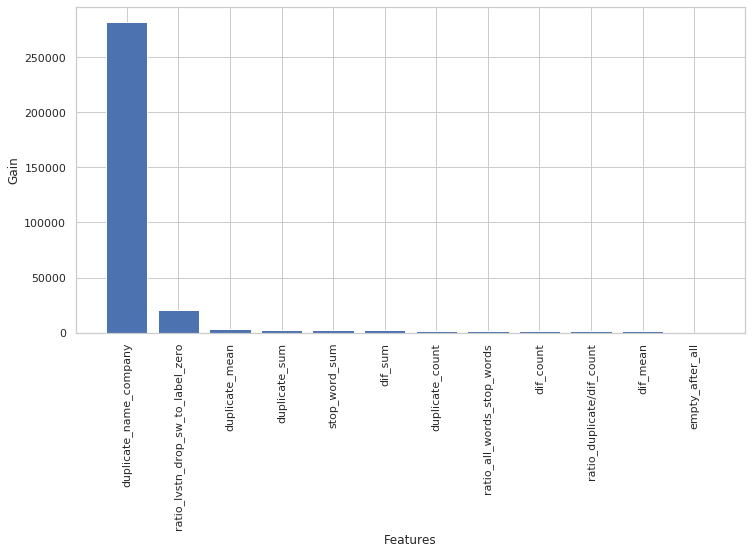

,Features,Gain
8,duplicate_name_company,281556.000000
11,ratio_lvstn_drop_sw_to_label_zero,20763.248383
3,duplicate_mean,3629.288025
2,duplicate_sum,2454.520935
9,stop_word_sum,2431.027954
5,dif_sum,2094.691956
1,duplicate_count,2080.580078
10,ratio_all_words_stop_words,1696.354980
4,dif_count,1526.122040
7,ratio_duplicate/dif_count,1511.890015


In [84]:
start = 0
stop = 30
size = (12,6)

df = table_gain_coef(model,features,start,stop)
gain_hist(df,size,start,stop)
display(df)

In [85]:
# make vector of answers (only predict target, no proba predict) for use it in next model
model = lgb.LGBMClassifier(**params)
model.fit(baseline_train[features].values,
          baseline_train["target"].values)


baseline_train['predict_1'] = (model.predict_proba(
    baseline_train[features].values)[:, 1] > probability_level).astype(np.int)

baseline_test['predict_1'] = (model.predict_proba(
    baseline_test[features].values)[:, 1] > probability_level).astype(np.int)

In [86]:
# make vector of answers (only predict target, no proba predict) for use it in next model
model = lgb.LGBMClassifier(**params)
model.fit(baseline_train[features].values,
          baseline_train["target"].values)


baseline_train['predict_1_proba'] = (model.predict_proba(
    baseline_train[features].values)[:, 1]*100).astype(np.int)

baseline_test['predict_1_proba'] = (model.predict_proba(
    baseline_test[features].values)[:, 1]*100).astype(np.int)

### *Second model: decission tree*
##### *Features to model:*
 - *predict from light gbm model* 
 - *h/f words count (650 features with label 0,1 or 2)*

In [87]:
baseline_train.columns[23:-13]

Index(['de_sum', 'sa_sum', 'cv_sum', 'rubber_sum', 's_sum', 'a_sum', 'imp_sum',
       'exp_sum', 'plastic_sum', 'e_sum',
       ...
       'abc_sum', 'swan_sum', 'ceat_sum', 'mat_sum', 'tedder_sum',
       'abrasives_sum', 'neumaticos_sum', 'ktn_sum', 'ming_sum', 'amster_sum'],
      dtype='object', length=650)

In [88]:
# select the features
features = ['predict_1']


for i in list(baseline_train.columns[23:-13]):
    features.append(i)

seed = 42

In [89]:
# provides train/test indices to split data in train/test sets
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)

tridx, cvidx = list(split.split(baseline_train[features],
                                baseline_train["target"]))[0]

print ('Split baseline data train',baseline_train.shape[0])
print (' - new train data:',tridx.shape[0])
print (' - new test data:',cvidx.shape[0])

Split baseline data train 497819
 - new train data: 398255
 - new test data: 99564


In [90]:
# learning decision tree classifier from sklearn
seed = 50

model = DecisionTreeClassifier(random_state=seed, min_samples_split=25, max_depth = 50)
model.fit(baseline_train.iloc[tridx][features].values,
          baseline_train.iloc[tridx]["target"].values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

In [91]:
# make predict proba and predict target
probability_level = 0.47
X = baseline_train
tridx = tridx
cvidx = cvidx
model = model

X_tr, X_cv = contingency_table(X,features,probability_level,tridx,cvidx,model)

train_matrix_confusion = matrix_confusion(X_tr)
cv_matrix_confusion = matrix_confusion(X_cv)

In [92]:
# check the report
report_score(train_matrix_confusion,
             cv_matrix_confusion,
             baseline_train,
             tridx,cvidx,
             X_tr,X_cv)

Matrix confusion on train data


,0_algorythm,1_algorythm
0_target,394931.0,398.0
1_target,254.0,2672.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395329
           1       0.87      0.91      0.89      2926

    accuracy                           1.00    398255
   macro avg       0.93      0.96      0.95    398255
weighted avg       1.00      1.00      1.00    398255

******************************************************


Matrix confusion on test(cv) data


,0_algorythm,1_algorythm
0_target,98726.0,106.0
1_target,73.0,659.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.86      0.90      0.88       732

    accuracy                           1.00     99564
   macro avg       0.93      0.95      0.94     99564
weighted avg       1.00      1.00      1.00     99564

******************************************************


In [ ]:
# X_tr[X_tr['False_Negative']==1][X_tr['mitsubishi_sum']==2][[
#     'pair_id','name_1','name_2','name_1_finish','name_2_finish',
#     'target','predict_1','predict_target','predict_proba'
# ]]

In [ ]:
# X_tr[X_tr['False_Negative']==1][[
#     'pair_id','name_1','name_2','name_1_finish','name_2_finish',
#     'target','predict_1','predict_target','predict_proba'
# ]]

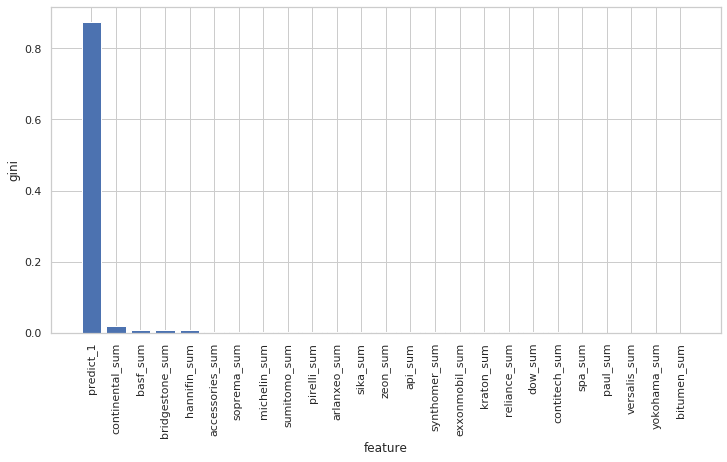

,feature,gini
0,predict_1,0.872506
183,continental_sum,0.019464
109,basf_sum,0.009331
69,bridgestone_sum,0.008218
298,hannifin_sum,0.007217
500,accessories_sum,0.003848
54,soprema_sum,0.003524
170,michelin_sum,0.003196
172,sumitomo_sum,0.002930
410,pirelli_sum,0.002893


In [93]:
start = 0
stop = 25
size = (12,6)

df = gini_df(model,features,start,stop)
gini_hist(df,size)
display(df)

## Check the model on all train samples before download predicts to validation
*light gbm and decission tree models*

In [94]:
model = DecisionTreeClassifier(random_state=seed, min_samples_split=25, max_depth=50)
model.fit(baseline_train[features].values,
          baseline_train["target"].values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

In [95]:
# make predict proba and predict target on train data
baseline_train['predict_to_csv'] = (model.predict_proba(
    baseline_train[features].values)[:, 1] > probability_level).astype(np.int)

# make predict proba and predict target on TEST data
baseline_test['predict_to_csv'] = (model.predict_proba(
    baseline_test[features].values)[:, 1] > probability_level).astype(np.int)

In [96]:
# predict balance on train
baseline_train['predict_to_csv'].value_counts()

0    494010
1      3809
Name: predict_to_csv, dtype: int64

In [97]:
# predict balance on test
baseline_test['predict_to_csv'].value_counts()

0    212179
1      1070
Name: predict_to_csv, dtype: int64

In [98]:
# report about precision, recall and f-1 score
print (classification_report(baseline_train["target"].values, baseline_train['predict_to_csv']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    494161
           1       0.87      0.91      0.89      3658

    accuracy                           1.00    497819
   macro avg       0.94      0.95      0.95    497819
weighted avg       1.00      1.00      1.00    497819



In [99]:
# make predict proba and predict target on train data
baseline_train['predict_proba_to_csv'] = 1-(model.predict_proba(
    baseline_train[features].values)[:, 0].astype(np.float))

# make predict proba and predict target on test data
baseline_test['predict_proba_to_csv'] = 1-(model.predict_proba(
    baseline_test[features].values)[:, 0].astype(np.float))

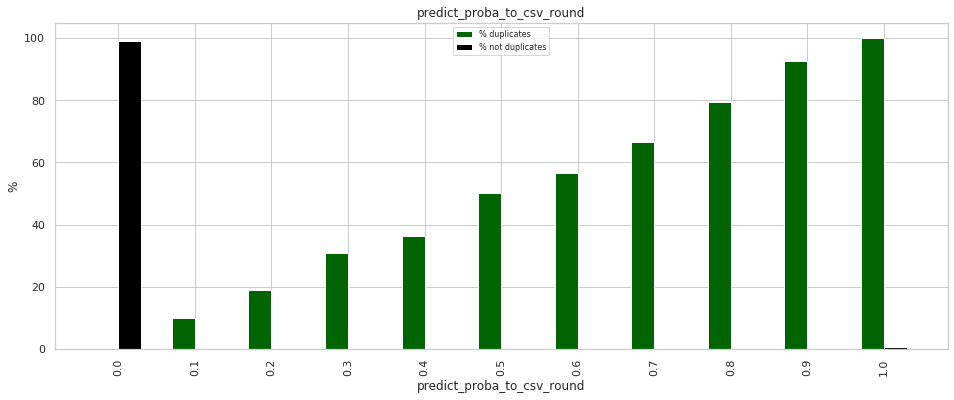

predict_proba_to_csv_round,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
target,,,,,,,,,,,
0,493405.00,170.00,69.00,27.00,7.00,1.0,460.00,3.00,7.00,10.0,2.00
1,281.00,19.00,16.00,12.00,4.00,1.0,601.00,6.00,27.00,127.0,2564.00
sum,493686.00,189.00,85.00,39.00,11.00,2.0,1061.00,9.00,34.00,137.0,2566.00
duplicates_%_(1),0.06,10.05,18.82,30.77,36.36,50.0,56.64,66.67,79.41,92.7,99.92
share_of_objects_%,99.20,0.00,0.00,0.00,0.00,0.0,0.20,0.00,0.00,0.0,0.50


In [100]:
baseline_train['predict_proba_to_csv_round'] = baseline_train['predict_proba_to_csv'].round(1)
data = baseline_train
analyse = 'predict_proba_to_csv_round'
title_print = 'no'
size = (16,6)

ct = contingency_table_2(data,analyse,title_print)
pair_hist(ct,size,title_print)
display(ct)

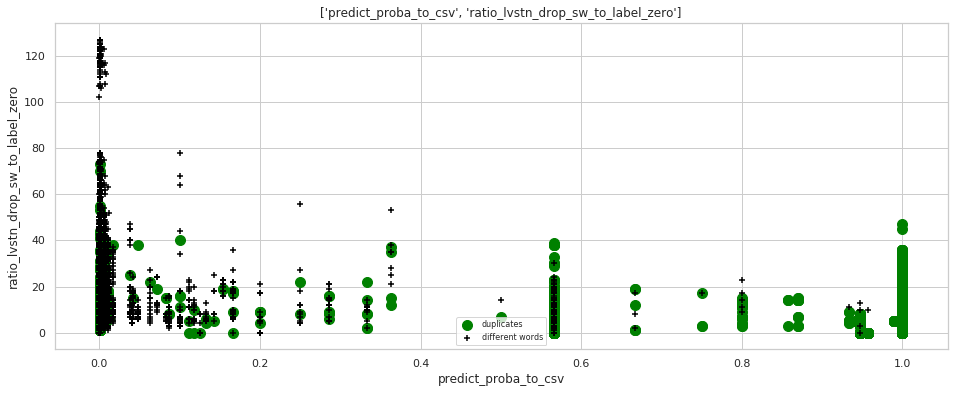

In [101]:
# scatter plot of two features (target and h/f word count)
data = baseline_train
analyse1 = 'predict_proba_to_csv'
analyse2 = 'ratio_lvstn_drop_sw_to_label_zero'
size = (16,6)
two_features(data,analyse1,analyse2,size)

In [102]:
# predict balance on test
baseline_test['predict_to_csv'].value_counts()

0    212179
1      1070
Name: predict_to_csv, dtype: int64

In [103]:
# select only dublicates names and look id, each name of companies and predict is the duplicate
baseline_test[baseline_test['predict_to_csv']==1][[
    'pair_id','name_1','name_2','predict_to_csv'
]]

,pair_id,name_1,name_2,predict_to_csv
114,115,nokian tyres plc,ооо нокиан тайерс,1
285,286,ineos styrolution ltd,styrolution america llc,1
306,307,canadian saddlery supply inc,canadian saddlery supply in,1
362,363,trelleborg ysh sa de cv,trelleborg engineeed products a,1
634,635,repsol ypf lubricantes y,repsol lubricantes y especialidades,1
...,...,...,...,...
211827,211828,sojitz co ltd,sojitz,1
211891,211892,jm logistics services sa de cv,jm lord international llc,1
211951,211952,sanyo corp,sanyo trading,1
212072,212073,goodyear do brasil productos de borracha ltda,goodyear inc,1


In [104]:
# select only NOT dublicates names and look id, each name of companies and predict is the duplicate
baseline_test[baseline_test['predict_to_csv']==0][[
    'pair_id','name_1','name_2','predict_to_csv'
]]

,pair_id,name_1,name_2,predict_to_csv
0,1,sun blinds decoration inc,indl de cuautitlan sa cv,0
1,2,eih ltd,dongguan wei shi plastic product co ltd,0
2,3,jsh ltd,arab shipbuilding and repair yard c,0
3,4,better industrial ltd,farmacap industria e comercio ltda,0
4,5,equipos inoxidables del norte sa de cv,bel inc,0
...,...,...,...,...
213244,213245,dyna logistics inc,jiangsu easero logistics ltd,0
213245,213246,dsi,kavalani sons wll,0
213246,213247,saint gobain abrasives,zarabi,0
213247,213248,covestro private ltd,terabytes private ltd,0


In [105]:
# download sample submission from csv file 
sample_sub = pd.read_csv('sample_submission.csv', index_col="pair_id")
# make the predict - our vector of answers
sample_sub['is_duplicate'] = (model.predict_proba(
    baseline_test[features].values)[:, 1] > probability_level).astype(np.int)

In [106]:
# download predict to csv file
sample_sub.to_csv('submission_lgbm_and_deep_tree.csv')

## Check the score  (f1 on test samples): 0.6699

# Заключение

Предложенное решение обладает существенным недостатком - оно сильно заточено под названия крупных холдингов, указанных в обучающей выборке и также сильно заточено под количество высокочастотных слов в паре. Это обстоятельство, как показала практика, делает решение сильно не стабильным.

Фактически, в последний день соревнования, пришло понимание, что для лучшего качества, следует не столько времени уделять составлению и использованию списка компаний из списка высокочастотных слов, сколько наиболее важно провести более тщательную предобработку и провести несколько подходов по удалению высокочастотных стоп-слов. На разных предобработках можно было бы создавать признаки, которые использовались в настоящем исследовании и объединять их, например, используя метод главных компонент (pca). Также стоило бы добавить коэффициент Жаро. На основании полученных признаков, обучать модель. 

Известно, что некоторые участники с топовыми решениями использовали нейронные сети. 

К сожалению, возможность загрузки и проверки решений, была отключена по завершению соревнования и мне не удалось проверить все свои идеи, а также идеи, которыми после соревнования поделились участники друг с другом.

## Идеи от участников соревнования

#### *1 IDEA (@vilka044)*

Несколько идей, выбили 0.63.
1. Очистка данных графом. Строим граф по связанным словам. Т.е. в словосочетании ООО Рога и копыта, связанными будут ООО - Рога, Рога - и, и - копыта. Потом убираем слова с числом связей больше N. Порог можно найти по boxplot, это 50-80. Очистка эффективно убирает слова типа ООО, industrial, ltd и пр.
(- к этому можно добавить еще видоизменение слов типа industrial: industria, industry, industrial etc, 
- а я их маркировал одинаковыми нечетким поиском. относил industry, industri, indastry и проч. схожее к одинаковым. в сомнительных случаях делал сравнение фонем, я использовал библиотеку fuzzywuzzy и pyjarowinklerpyjarowinkler. Джаро-Винкле вообще хорошо зашёл, он и в поиске опечаток хороший результат даёт, лучше, чем левенштейн и н-граммы)

2. Валидация. После очистки группируем пары по признаку "первые N символов 1 слова есть во 2". Получается примерно 1700 групп разного размера. Затем жадным алгоритмом раскидываем группы по фолдам. Вот, например, кросс-валидация по решению на 0.63.
Сори что оси не подписаны, рабочий вариант - по y F1, по x - пороги от 0.1 до 0.9 для proba. Для предикта взят порог 0.7 (по x – 6)

#### *2 IDEA (@Affernus)*

Я пробовал косинусное и евклидово, не взлетели. Tfidf сильно переучивался, пробовал tfidf по буквам и n-gram, полученные векторы испрльзовал для косинусного и евклидова. Но лучше себя показали расстояние джаро и левенштейн из fuzzy

Для очистки elfs (форм собственности) юзал словарь с ними. Города и страны тоже выделял по словарю. Пробовал по ним делать отдельные признаки.

А вчера я выяснил, что pca на расстояние джаро + расстояние левенштейна позволяет отсечь 99 процентов данных как ноли. От трейна оставалось около 7 тысяч данных, где классы распределены пополам. Но это произошло в 8 вечера и единственное, что я потом успел - положить на остаток стек из всего, что попалось под руку (катбус, лгбм, иксжибуст, логрег и т.д.). Эта композиция шикарно поделила трейн и не очень - тест (там 0.7-0.72). На таких данных можно было уже и берт и скайпай попробовать обучить, но времени не хватило(

Ну да) я делал частоты слов, расстояния джаро, левенштейна, схожесть по н граммам, косинусное и евклидово на тфидф по буквам и нграммам, доли совпадающих слов, попадание в список бинго из самых частых совпадающих слов..

#### *3 IDEA (@TorricK)*

0.85. Базовая обработка на пробелы, lowercase, символы. Выкидывал страны и типы организаций. Затем аугментации, где добавлял грязные данные и менял порядок слов. Оверсэмплинг. mBERT base файнтюнинг и ансамбль из трёх лучших моделей с разной инициализацией весов. Вдохновлялся кагглом токсик коммент детекшен.

#### *4 IDEA (@ivanglebov)*

ask: А на чем Берт учил, ну типа какой таргет и что на вход, если не секрет, я обучал sentence bert, и потом использовал косинусное расстояние между эмбедингами name1 name2, но выше 0.64 это не давало
answer:: Не учил, а файнтюнил) через huggingface интерфейс подавал на вход пару и получал CLS выход
answer:Таргет 1 или 0
ask: Ну тоесть одна сеть, на вход name1, name2, объединенные в один текст, и класификация cks токена?
answer: Там можно подавать два отдельных предложения и таргет
answer: Задача paraphrasing detection на BErt как пример
https://github.com/UKPLab/sentence-transformers
вообще просто закинул в первом пример документации было,  две эпохи и трешхол 0.6 - 0.64 лб
У меня с  Roberta скор 0.72. Данные никак не обрабатывал, просто сконкатинировал name_1 и name_2 как есть)).  Colab + TPU.

#### *IDEA 6*
По словарям хорошо зашли вариации. Т.е. добавить разных окончаний (s, ing, ings), заменить сочетания букв на другие (zh-> j и наоборот). Расширяло словарь в 10ки раз, при этом давало на +0.15 на паблике

#### *IDEA 7*
Транслитерация всего и вся: https://github.com/wikimedia/pywikibot/blob/master/pywikibot/userinterfaces/transliteration.py